In [1]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.simplefilter('always')

from scripts.a_data_loading_cleaning import run_load_clean_diagnose_data

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data Loading & Cleaning

In [2]:
csv_path = "results/scenarios_results_complete_tinyllama_17_04.csv"
df = run_load_clean_diagnose_data(csv_path)

✅ All rows have consistent 'total_generated_tokens' = 16384
----------------------------------------------------------------------------------------------------
✅ FLOPs value is constant: 16949970993152
Original distribution:
flops
16949970993152    38
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
✅ Total generated tokens value is constant: 16384
Original distribution:
total_generated_tokens
16384    38
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


# Basic understanding on contents

In [3]:
print(f"number of observation: {len(df)}")
print(f"number of scenarios: {len(df['config_name'].unique())}")
print(f"distribution of scenarios:{df['config_name'].value_counts()}")

number of observation: 38
number of scenarios: 12
distribution of scenarios:config_name
A5_Parallel_Overdrive                     4
A4_Latency_Ignorance_Exploit              4
R7_anti_platonic_ideal                    3
A2_Precision_Minimalist                   3
R3_Balanced_Enterprise_Service            3
R4_High_Load_Cloud_API_Deployment         3
R6_Medium_Scale_Language_Model_Serving    3
R2_Low_Latency_Chatbot_Deployment         3
R5_Real_Time_Mobile_Inference             3
A3_Quantisation_Gaming                    3
A0_platonic_ideal                         3
A1_Max_Throughput_Exploit                 3
Name: count, dtype: int64


In [4]:
cols_to_describe = [
    'total_energy_kwh',
    'total_inference_time_sec',
    'average_latency_ms_per_batch',
    'throughput_queries_per_sec',
    'throughput_tokens_per_sec',
    'cpu_energy_total',
    'gpu_energy_total',
    'flops_per_token',
    'energy_per_token_kwh',
    'divergence_energy_flops'
]

df[cols_to_describe].describe()

,total_energy_kwh,total_inference_time_sec,average_latency_ms_per_batch,throughput_queries_per_sec,throughput_tokens_per_sec,cpu_energy_total,gpu_energy_total,flops_per_token,energy_per_token_kwh,divergence_energy_flops
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,3.800000e+01,3.800000e+01,3.800000e+01
mean,0.036730,144.601134,5807.480391,10.728207,1373.210559,0.008885,0.027794,1.034544e+09,2.241823e-06,2.166967e-15
std,0.086453,308.222714,3183.434520,11.133849,1425.132645,0.016954,0.071289,0.000000e+00,5.276688e-06,5.100496e-15
min,0.000641,3.469703,2795.350058,0.114685,14.679672,0.000111,0.000374,1.034544e+09,3.914814e-08,3.784095e-17
25%,0.001770,7.165045,3236.499330,2.315328,296.361999,0.000958,0.000772,1.034544e+09,1.080483e-07,1.044405e-16
50%,0.006464,25.161361,4137.649510,6.752452,864.313915,0.001693,0.004600,1.034544e+09,3.945152e-07,3.813421e-16
75%,0.014383,55.284692,9240.515983,18.406045,2355.973763,0.002758,0.011335,1.034544e+09,8.778632e-07,8.485507e-16
max,0.325172,1116.101213,11328.795747,36.890766,4722.018095,0.057487,0.267403,1.034544e+09,1.984693e-05,1.918422e-14


📊 Plotting histogram...


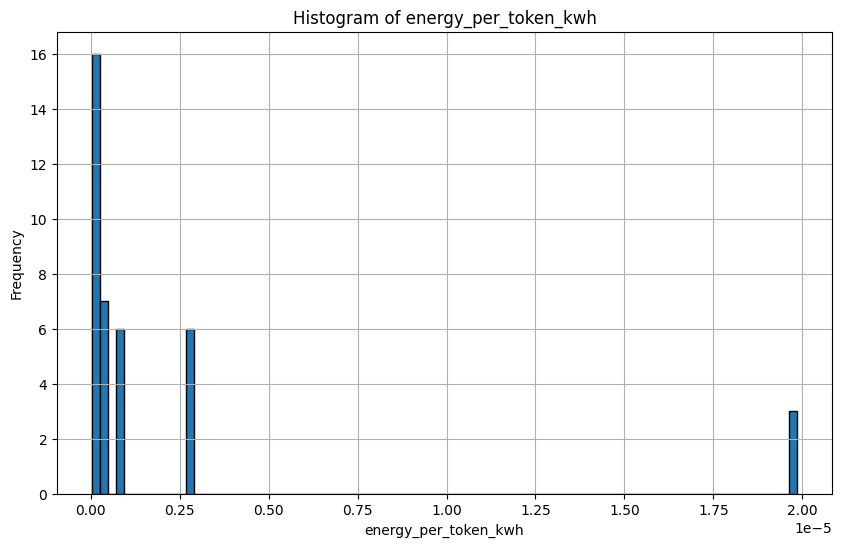

📦 Plotting boxplot...


/Users/henrybaker/repositories/thesis_analysis/scripts/b_exploratory_data_analysis.py:28: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  plt.boxplot(data[column].dropna(), vert=False)


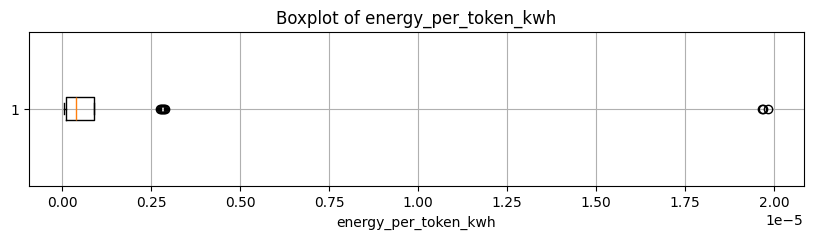

🔬 Scatter: Energy vs FLOPs...


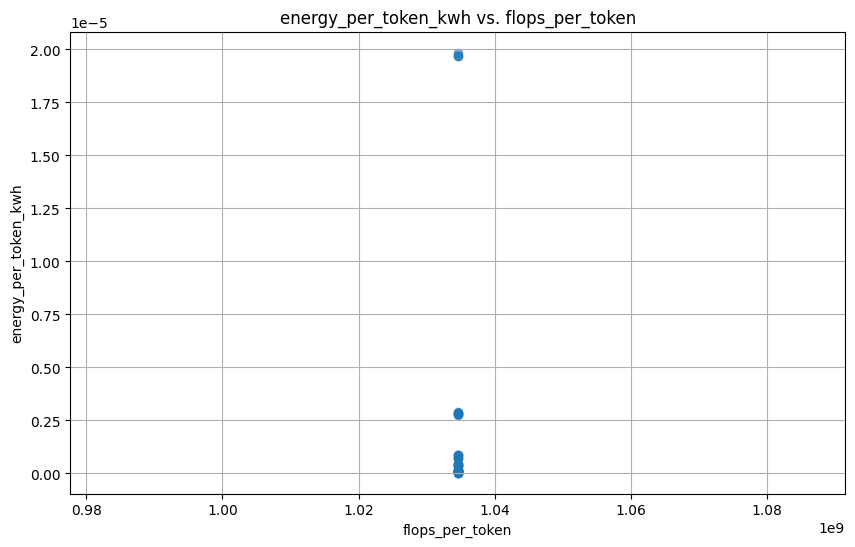

📈 Scatter: Divergence vs Batch Size...


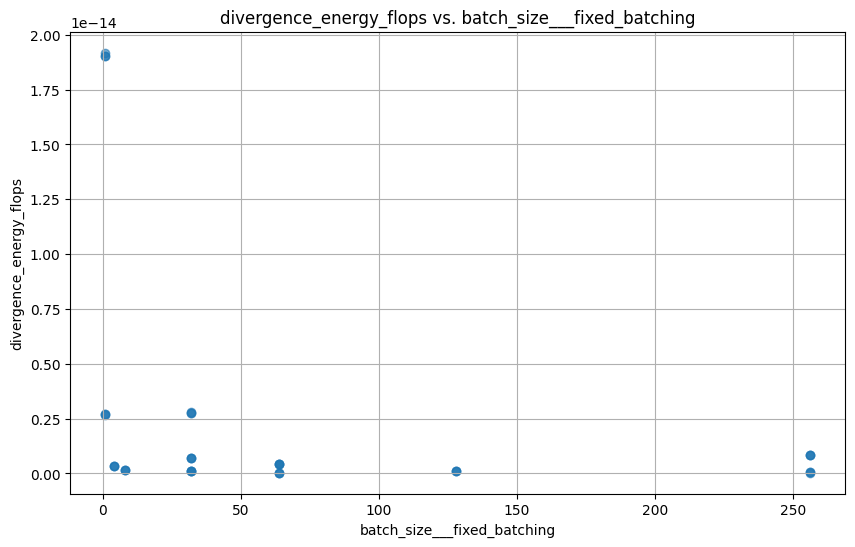

🔗 Correlation matrix...


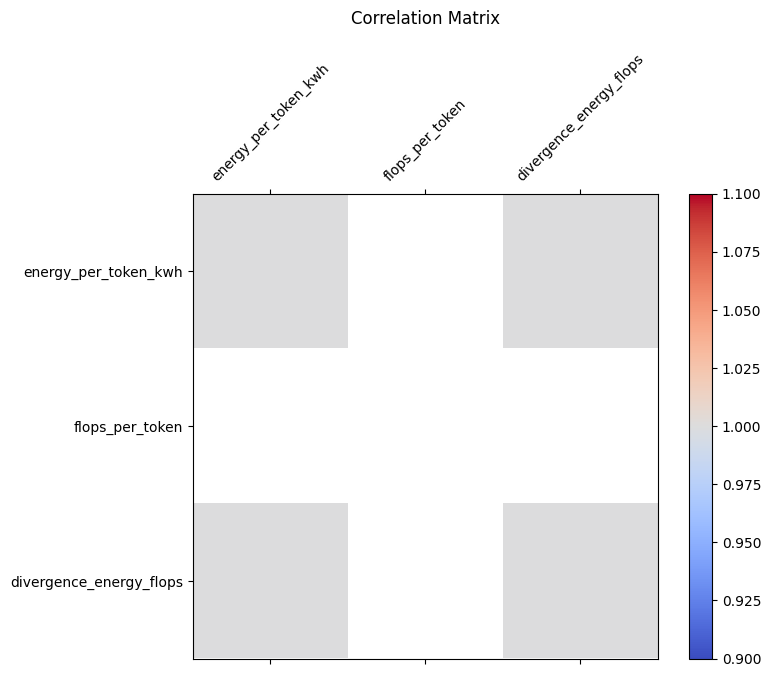

In [5]:
from scripts.b_exploratory_data_analysis import (
    plot_histogram,
    plot_boxplot,
    plot_scatter,
    plot_divergence,
    plot_correlation_matrix,
    plot_all_diagnostics
)

plot_all_diagnostics(df)

To do:
- [X] get the outliers
- [ ] unpack the divergence plot more
- [ ] work on the correlation matrix

In [6]:
# outliers:
outliers = df[(df['energy_per_token_kwh'] - df['energy_per_token_kwh'].mean()).abs() > 3 * df['energy_per_token_kwh'].std()]
print(outliers[['config_name', 'energy_per_token_kwh']])


               config_name  energy_per_token_kwh
2   R7_anti_platonic_ideal               0.00002
19  R7_anti_platonic_ideal               0.00002
32  R7_anti_platonic_ideal               0.00002


# Basic stats

In [7]:
max_scenario = df[df['energy_per_token_kwh'] == df['energy_per_token_kwh'].max()]
min_scenario = df[df['energy_per_token_kwh'] == df['energy_per_token_kwh'].min()]

print(f"Max Scenario:\n {max_scenario[['config_name', 'energy_per_token_kwh']]}; \n \nMin Scenario:\n {min_scenario[['config_name', 'energy_per_token_kwh']]}")

Max Scenario:
                config_name  energy_per_token_kwh
32  R7_anti_platonic_ideal               0.00002; 
 
Min Scenario:
           config_name  energy_per_token_kwh
30  A0_platonic_ideal          3.914814e-08


In [8]:
range_ = df['energy_per_token_kwh'].max() - df['energy_per_token_kwh'].min()
mean_ = df['energy_per_token_kwh'].mean()
range_scaled = range_ / mean_
print(f"the energy range is {range_scaled:.2%} of the average energy.")

the energy range is 883.56% of the average energy.


In [9]:
cv = df['energy_per_token_kwh'].std() / df['energy_per_token_kwh'].mean()
print(f"the coefficient of variation is {cv:.2%} of the average energy.") 
print(f"The standard deviation is {cv:.2} of the mean.")

the coefficient of variation is 235.37% of the average energy.
The standard deviation is 2.4 of the mean.


<Axes: title={'center': 'Distribution of Normalised Energy per Token'}, xlabel='Energy per Token (normalised by mean) \n"How many times bigger (or smaller) is this value than the average?"', ylabel='Frequency'>

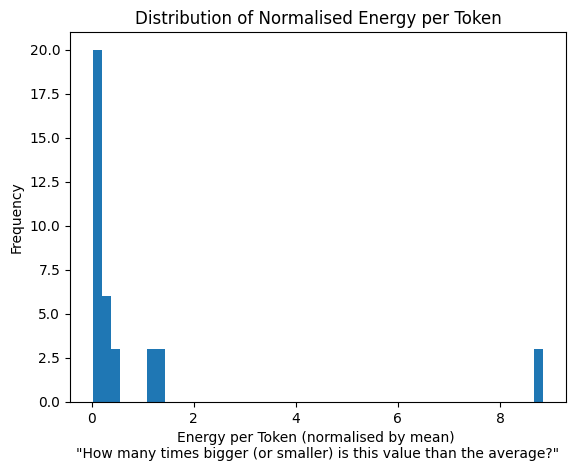

In [10]:
(df['energy_per_token_kwh'] / df['energy_per_token_kwh'].mean()).plot(
    kind='hist',
    bins=50,
    title='Distribution of Normalised Energy per Token',
    xlabel='Energy per Token (normalised by mean) \n"How many times bigger (or smaller) is this value than the average?"',
    ylabel='Frequency'
)

In [11]:
models = df['model'].unique()
print(f"Using models: {models}")

Using models: ['TinyLlama/TinyLlama-1.1B-Chat-v1.0']


# Absolute Numbers
NB; THIS IS WITH TINY LLAMA -> DO WITH MORE REPRESENTATIVE LLM

1. Incl best vs worst case
2. Removing extremes -> compare between realistic vs artificial settings

In [12]:
from scripts.f_scenario_analysis import compare_energy_to_appliances

In [13]:
compare_energy_to_appliances(df)

== ASSUMING AVERAGE LENGTH: 300 TOKENS ==

Models: ['TinyLlama/TinyLlama-1.1B-Chat-v1.0']

=== Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0 ===

-- Scenario: Full dataset (38 obs) --
# of responses to match...
    ...iPhone_charge
            worst-case:     1.68
            best-case:      851.47
            diff:           1.68
            mean-case:      14.87
    ...laptop_charge
            worst-case:     8.40
            best-case:      4257.33
            diff:           8.41
            mean-case:      74.34
    ...wifi_router_24h
            worst-case:     4.03
            best-case:      2043.52
            diff:           4.04
            mean-case:      35.69
    ...streaming_1hr
            worst-case:     8.40
            best-case:      4257.33
            diff:           8.41
            mean-case:      74.34
    ...google_search
            worst-case:     0.05
            best-case:      25.54
            diff:           0.05
            mean-case:      0.45
    ...ket

NB: this is the TinyLLama model -> do scenarios with largest possible LLaMa model!
Also, do this with non-extreme (all the realistic scenarios vs non-realistic scenarios)

# Modeling

In [ ]:
df.columns

In [ ]:
from scripts.d_base_regression import run_full_regression_analysis, preprocess_data

df = preprocess_data(df)

# With custom predictors
custom_predictors = [
                     "num_processes", 
                     "batch_size_numeric", 
                     "C(decoder_config_decoding_mode)", 
                     "C(latency_simulation_simulate)", 
                     "C(fp_precision)", 
                     "C(quantization)", 
                     "total_inference_time_sec"
                     ]
run_full_regression_analysis(df, predictors=custom_predictors)
